## Note that this notebook require GPU. 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import sys
sys.path.append("../../../chrombpnet/")
from training.utils.losses import multinomial_nll
from training.utils import one_hot
#from training.utils.data_utils import load_data
#from metrics import softmax 
import scipy.stats
import pyBigWig
import pyfaidx

In [2]:
### Here add a line for downloading models and corresponding file from Zenodo repository 

In [3]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]


def load_test_data(peaks_file, nonpeaks_file, genome_fasta, cts_bw_file,
                   test_chrs, inputlen, outputlen):
    assert(inputlen%2==0)

    peaks_df = pd.read_csv(peaks_file, sep='\t', names=NARROWPEAK_SCHEMA)
    nonpeaks_df = pd.read_csv(nonpeaks_file, sep='\t', names=NARROWPEAK_SCHEMA)

    test_peaks_df = peaks_df[peaks_df['chr'].isin(test_chrs)]
    test_nonpeaks_df = nonpeaks_df[nonpeaks_df['chr'].isin(test_chrs)]

    cts_bw = pyBigWig.open(cts_bw_file)
    genome = pyfaidx.Fasta(genome_fasta)

    test_peaks_seqs, test_peaks_cts = get_seq_cts(test_peaks_df,
                                                  genome,
                                                  cts_bw,
                                                  inputlen,
                                                  outputlen)

    test_nonpeaks_seqs, test_nonpeaks_cts = get_seq_cts(test_nonpeaks_df,
                                                        genome,
                                                        cts_bw,
                                                        inputlen,
                                                        outputlen)

    cts_bw.close()
    genome.close()

    return test_peaks_seqs, test_peaks_cts, test_nonpeaks_seqs, test_nonpeaks_cts

In [4]:
def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

In [5]:
def min_max_norm(column,global_max,global_min):
    min_val = global_min
    max_val = global_max
    result = (column - min_val) / (max_val - min_val)
    return result

In [6]:
def get_cts(peaks_df, bw, width):
    """
    Fetches values from a bigwig bw, given a df with minimally
    chr, start and summit columns. Summit is relative to start.
    Retrieves values of specified width centered at summit.
    "cts" = per base counts across a region
    """
    vals = []
    for i, r in peaks_df.iterrows():
        vals.append(np.nan_to_num(bw.values(r['chr'], 
                                            r['start'] + r['summit'] - width//2,
                                            r['start'] + r['summit'] + width//2)))


def get_seq(peaks_df, genome, width):
    """
    Same as get_cts, but fetches sequence from a given genome.
    """
    vals = []
    for i, r in peaks_df.iterrows():
        vals.append(str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)]))

    return one_hot.dna_to_one_hot(vals)

def get_seq_cts(peaks_df, genome, bw, input_width, output_width):
    seq = get_seq(peaks_df, genome, input_width)
    cts = get_cts(peaks_df, bw, output_width)

    return seq, cts



In [7]:
def profiles_for_motif(model, model_bias, model_wobias, seqs, motif):
    w_mot_seqs = seqs.copy()
    mid = w_mot_seqs.shape[1]//2 - len(motif)//2
    w_mot_seqs[:, mid:mid+len(motif)] = one_hot.dna_to_one_hot([motif])
    
    raw_seqs_pred_bias, raw_seqs_pred_cts = model_bias.predict(seqs, verbose=True)
    w_mot_seqs_pred_bias, w_mot_seqs_pred_cts = model_bias.predict(w_mot_seqs, verbose=True)
    
    wo_mot_pred_w_bias, wo_mot_pred_w_bias_cts = model.predict(seqs, verbose=True)

    w_mot_pred_unplug_bias, _ = model_wobias.predict(w_mot_seqs,verbose=True)
                                               
    w_mot_pred_w_bias, w_mot_pred_w_bias_cts = model.predict(w_mot_seqs, verbose=True)
    
    return(softmax(raw_seqs_pred_bias), softmax(w_mot_seqs_pred_bias), 
           softmax(wo_mot_pred_w_bias), softmax(w_mot_pred_w_bias), 
           softmax(w_mot_pred_unplug_bias),
           wo_mot_pred_w_bias_cts, w_mot_pred_w_bias_cts)
    ## This is for outputting with and without bias
    #return(softmax(w_mot_pred_unplug_bias + w_mot_seqs_pred_bias), softmax(w_mot_pred_unplug_bias))

## JC_0057 (NR4A) vs WC_1094 (NR4A-like) motif footprinting

### Sman muscle model

In [8]:
### Don't forget to update these paths 
with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    model_bias = tf.keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/muscle/muscle_bias_model_scaled.h5")    
    model = tf.keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/muscle/muscle_chrombpnet.h5")  
    model_wobias = tf.keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/muscle/muscle_chrombpnet_wo_bias.h5") 

2024-07-24 21:54:53.475478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-24 21:54:53.476412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-24 21:54:53.485125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-24 21:54:53.485837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-24 21:54:53.486502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [9]:
INP_LEN = model_bias.input_shape[1]
OUT_LEN = model_bias.output_shape[0][1]

INP_LEN, OUT_LEN

(2114, 1000)

In [10]:
TEST_CHR = ["SM_V7_4","SM_V7_2","SM_V7_1","SM_V7_5","SM_V7_6","SM_V7_7"]
VAL_CHR = ["SM_V7_3"]

In [11]:
## Don't forget to update these paths 
test_peaks_seqs, test_peaks_cts, test_nonpeaks_seqs, test_nonpeaks_cts = \
    load_test_data("./ChromBPNet/chrombpnet_models/Sman/fold_1/muscle/muscle_filtered.peaks.bed", 
                   "./ChromBPNet/chrombpnet_models/Sman/fold_1/muscle/muscle_filtered.nonpeaks.bed", 
                   "./Refs/SM_V7/Schisto_PRJEA36577.WBPS15.genomic.fa", 
                   "./ChromBPNet/Coverage/Sman/muscle_unstranded.bw",
                   TEST_CHR, INP_LEN, OUT_LEN)

### WC_1094

In [18]:
raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias_novel, wo_mot_w_bias_cts, w_mot_w_bias_cts \
    = profiles_for_motif(model, model_bias, model_wobias,test_nonpeaks_seqs[1000:9000], "AAATGTCAAAATGTCAAAATGTCA")

250/250 [==============================] - 133s 535ms/step


In [19]:
np.median(w_mot_w_bias_cts - wo_mot_w_bias_cts)

0.23420405

In [20]:
#def plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias,pred_unplug_bias, pred_unplug_bias_novel,save_path,start=450, end=550):
def plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias,pred_unplug_bias_novel,save_path,start=450, end=550):
    plt.rcParams["figure.figsize"] = (2.5,2.5)
    width = end - start
    a = np.array(pred_unplug_bias_novel[:, start:end].mean(0))
    b = np.array(pred_wo_motif_w_bias[:, start:end].mean(0))
    global_max = np.max(a)
    global_min = np.median(b)
    print(global_max)
    plt.plot(range(width), min_max_norm(pred_unplug_bias_novel[:, start:end].mean(0),global_max,global_min), linewidth=1, label='with motif' )
    plt.plot(range(width), min_max_norm(pred_wo_motif_w_bias[:, start:end].mean(0),global_max,global_min), '--', linewidth=1, label='without motif')
    plt.legend()
    plt.ylim([-0.45,1.2])
    plt.savefig(save_path)
    plt.show()
    plt.plot(range(width), raw_mot_bias[:, start:end].mean(0), label='bias w/ motif')
    plt.plot(range(width), raw_bias[:, start:end].mean(0), '--', label='bias w/o motif')
    plt.legend()
    plt.show()

0.0022774744


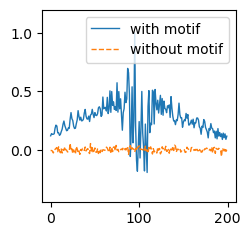

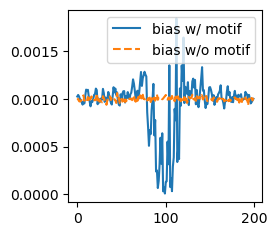

In [21]:
plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias,pred_unplug_bias_novel,save_path='./Plots/EDFig5/PanelED5e_bottomright.svg',start=400, end=600)

### JC_0057

In [22]:
# Here I want to test NR4 muscle 
raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias, wo_mot_w_bias_cts, w_mot_w_bias_cts \
    = profiles_for_motif(model, model_bias, model_wobias,test_nonpeaks_seqs[1000:9000], "AAAGGTCAAAAGGTCAAAAGGTCA")

250/250 [==============================] - 133s 534ms/step


In [23]:
np.median(w_mot_w_bias_cts - wo_mot_w_bias_cts)

0.025487185

In [24]:
#def plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias,pred_unplug_bias, pred_unplug_bias_novel,save_path,start=450, end=550):
def plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias,pred_unplug_bias,pred_unplug_bias_novel,save_path,start=450, end=550):
    plt.rcParams["figure.figsize"] = (2.5,2.5)
    width = end - start
    a = np.array(pred_unplug_bias_novel[:, start:end].mean(0))
    b = np.array(pred_wo_motif_w_bias[:, start:end].mean(0))
    global_max = np.max(a)
    global_min = np.median(b)
    print(global_max)
    plt.plot(range(width), min_max_norm(pred_unplug_bias[:, start:end].mean(0),global_max,global_min), linewidth=1, label='with motif' )
    plt.plot(range(width), min_max_norm(pred_wo_motif_w_bias[:, start:end].mean(0),global_max,global_min), '--', linewidth=1, label='without motif')
    plt.legend()
    plt.ylim([-0.45,1.2])
    plt.savefig(save_path)
    plt.show()
    plt.plot(range(width), raw_mot_bias[:, start:end].mean(0), label='bias w/ motif')
    plt.plot(range(width), raw_bias[:, start:end].mean(0), '--', label='bias w/o motif')
    plt.legend()
    plt.show()

0.0022774744


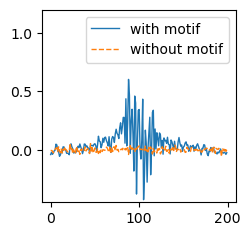

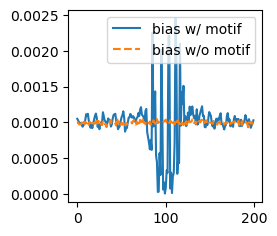

In [25]:
plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias,pred_unplug_bias_novel,save_path='./Plots/EDFig5/PanelED5e_bottomleft.svg',start=400, end=600)

### Sman S1/vitellocyte model

In [26]:
### Don't forget to update these paths 
with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    model_bias = tf.keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/S1_vitellocyte/S1_vitellocyte_bias_model_scaled.h5")    
    model = tf.keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/S1_vitellocyte/S1_vitellocyte_chrombpnet.h5")  
    model_wobias = tf.keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/S1_vitellocyte/S1_vitellocyte_chrombpnet_wo_bias.h5") 

/opt/conda/lib/python3.9/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning:  is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


In [27]:
INP_LEN = model_bias.input_shape[1]
OUT_LEN = model_bias.output_shape[0][1]

INP_LEN, OUT_LEN

(2114, 1000)

In [28]:
TEST_CHR = ["SM_V7_4","SM_V7_2","SM_V7_1","SM_V7_5","SM_V7_6","SM_V7_7"]
VAL_CHR = ["SM_V7_3"]

In [29]:
## Don't forget to update these paths 
test_peaks_seqs, test_peaks_cts, test_nonpeaks_seqs, test_nonpeaks_cts = \
    load_test_data("./ChromBPNet/chrombpnet_models/Sman/fold_1/S1_vitellocyte/S1_vitellocyte_filtered.peaks.bed", 
                   "./ChromBPNet/chrombpnet_models/Sman/fold_1/S1_vitellocyte/S1_vitellocyte_filtered.nonpeaks.bed", 
                   "./Refs/SM_V7/Schisto_PRJEA36577.WBPS15.genomic.fa", 
                   "./ChromBPNet/Coverage/Sman/S1_vitellocytes_unstranded.bw",
                   TEST_CHR, INP_LEN, OUT_LEN)

### JC_0057

In [31]:
# Here I want to test NR4 muscle 
raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias, wo_mot_w_bias_cts, w_mot_w_bias_cts \
    = profiles_for_motif(model, model_bias, model_wobias,test_nonpeaks_seqs[1000:9000], "AAAGGTCAAAAGGTCAAAAGGTCA")

250/250 [==============================] - 134s 536ms/step


In [32]:
np.median(w_mot_w_bias_cts - wo_mot_w_bias_cts)

1.3089197

In [33]:
#def plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias,pred_unplug_bias, pred_unplug_bias_novel,save_path,start=450, end=550):
def plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias,pred_unplug_bias,save_path,start=450, end=550):
    plt.rcParams["figure.figsize"] = (2.5,2.5)
    width = end - start
    a = np.array(pred_unplug_bias[:, start:end].mean(0))
    b = np.array(pred_wo_motif_w_bias[:, start:end].mean(0))
    global_max = np.max(a)
    global_min = np.median(b)
    print(global_max)
    plt.plot(range(width), min_max_norm(pred_unplug_bias[:, start:end].mean(0),global_max,global_min), linewidth=1, label='with motif' )
    plt.plot(range(width), min_max_norm(pred_wo_motif_w_bias[:, start:end].mean(0),global_max,global_min), '--', linewidth=1, label='without motif')
    plt.legend()
    plt.ylim([-0.45,1.2])
    plt.savefig(save_path)
    plt.show()
    plt.plot(range(width), raw_mot_bias[:, start:end].mean(0), label='bias w/ motif')
    plt.plot(range(width), raw_bias[:, start:end].mean(0), '--', label='bias w/o motif')
    plt.legend()
    plt.show()

0.004381655


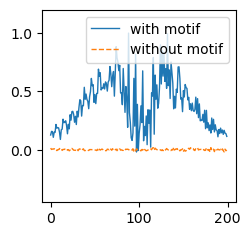

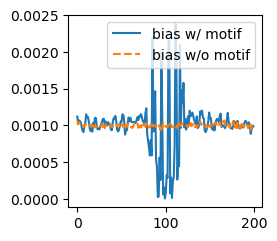

In [34]:
plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias,save_path='./Plots/EDFig5/PanelED5e_topleft.svg',start=400, end=600)

### WC_1094

In [35]:
raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias_novel, wo_mot_w_bias_cts, w_mot_w_bias_cts \
    = profiles_for_motif(model, model_bias, model_wobias,test_nonpeaks_seqs[1000:9000], "AAATGTCAAAATGTCAAAATGTCA")

250/250 [==============================] - 133s 535ms/step


In [36]:
np.median(w_mot_w_bias_cts - wo_mot_w_bias_cts)

0.0143249035

In [37]:
#def plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias,pred_unplug_bias, pred_unplug_bias_novel,save_path,start=450, end=550):
def plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias,pred_unplug_bias,pred_unplug_bias_novel,save_path,start=450, end=550):
    plt.rcParams["figure.figsize"] = (2.5,2.5)
    width = end - start
    a = np.array(pred_unplug_bias[:, start:end].mean(0))
    b = np.array(pred_wo_motif_w_bias[:, start:end].mean(0))
    global_max = np.max(a)
    global_min = np.median(b)
    print(global_max)
    plt.plot(range(width), min_max_norm(pred_unplug_bias_novel[:, start:end].mean(0),global_max,global_min), linewidth=1, label='with motif' )
    plt.plot(range(width), min_max_norm(pred_wo_motif_w_bias[:, start:end].mean(0),global_max,global_min), '--', linewidth=1, label='without motif')
    plt.legend()
    plt.ylim([-0.45,1.2])
    plt.savefig(save_path)
    plt.show()
    plt.plot(range(width), raw_mot_bias[:, start:end].mean(0), label='bias w/ motif')
    plt.plot(range(width), raw_bias[:, start:end].mean(0), '--', label='bias w/o motif')
    plt.legend()
    plt.show()

0.004381655


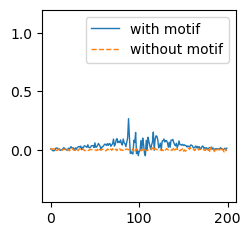

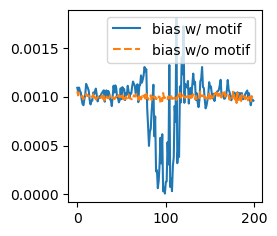

In [38]:
plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias,pred_unplug_bias,pred_unplug_bias_novel,save_path='./Plots/EDFig5/PanelED5e_topright.svg',start=400, end=600)

## WC motif footprinting

### WC_1100

In [2]:
with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    model_bias = tf.keras.models.load_model("./ChromBPNet/chrombpnet_models/Mlig/fold_1/cathepsin/cathepsin_bias_model_scaled.h5")    
    model = tf.keras.models.load_model("./ChromBPNet/chrombpnet_models/Mlig/fold_1/cathepsin/cathepsin_chrombpnet.h5")  
    model_wobias = tf.keras.models.load_model("./ChromBPNet/chrombpnet_models/Mlig/fold_1/cathepsin/cathepsin_chrombpnet_wo_bias.h5") 

2024-04-26 01:47:49.506167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-26 01:47:49.507014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-26 01:47:49.515892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-26 01:47:49.516600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-26 01:47:49.517282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [3]:
INP_LEN = model_bias.input_shape[1]
OUT_LEN = model_bias.output_shape[0][1]

INP_LEN, OUT_LEN

(2114, 1000)

In [4]:
TEST_CHR = ["ML45REF0001", "ML45REF0002", "ML45REF0004", "ML45REF0003", "ML45REF0005", "ML45REF0006", "ML45REF0007", "ML45REF0008", "ML45REF0009", "ML45REF0008", "ML45REF0020", "ML45REF0019", "ML45REF0032", "ML45REF0035", "ML45REF0023", "ML45REF0026", "ML45REF0016", "ML45REF0022"]
VAL_CHR = ["ML45REF0009", "ML45REF0010", "ML45REF0011", "ML45REF0027", "ML45REF0056", "ML45REF0055", "ML45REF0021", "ML45REF0022", "ML45REF0023", "ML45REF0028", "ML45REF0110", "ML45REF0031", "ML45REF0030", "ML45REF0032", "ML45REF0033", "ML45REF0144", "ML45REF0167", "ML45REF0158"]

In [8]:
test_peaks_seqs, test_peaks_cts, test_nonpeaks_seqs, test_nonpeaks_cts = \
    load_test_data("./ChromBPNet/chrombpnet_models/Mlig/fold_1/cathepsin/cathepsin_filtered.peaks.bed", 
                   "./ChromBPNet/chrombpnet_models/Mlig/fold_1/cathepsin/cathepsin_filtered.nonpeaks.bed", 
                   "./Refs/Mlig_4_5.v5/Mlig_4_5.fa", 
                   "./ChromBPNet/Coverage/Mlig/cathepsin_all_unstranded.bw",
                   TEST_CHR, INP_LEN, OUT_LEN)

In [10]:
def plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias,save_path, start=450, end=550):
    plt.rcParams["figure.figsize"] = (6,4)
    width = end - start
    plt.plot(range(width), pred_unplug_bias[:, start:end].mean(0), label='corrected')
    plt.plot(range(width), pred_wo_motif_w_bias[:, start:end].mean(0), '--', label='uncorrected w/o motif')
    plt.ylim([0.00025,0.0025])
    plt.savefig(save_path,format="svg")

    plt.legend()
    plt.show()

    plt.plot(range(width), raw_mot_bias[:, start:end].mean(0), label='bias w/ motif')
    plt.plot(range(width), raw_bias[:, start:end].mean(0), '--', label='bias w/o motif')
    plt.legend()
    plt.show()

In [57]:
raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias, wo_mot_w_bias_cts, w_mot_w_bias_cts \
    = profiles_for_motif(model, model_bias, model_wobias, test_nonpeaks_seqs[1000:3000], "ATAAACACAATGTGATAAACACAATGTG")

63/63 [==============================] - 17s 279ms/step


In [58]:
np.median(w_mot_w_bias_cts - wo_mot_w_bias_cts)

0.09847903

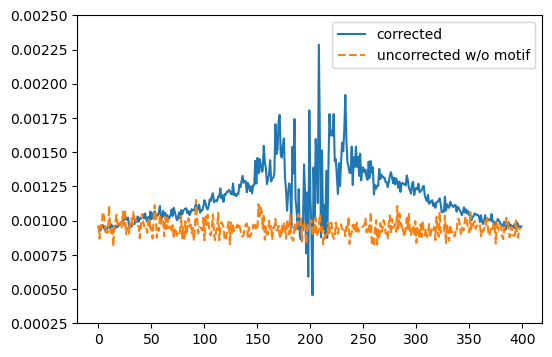

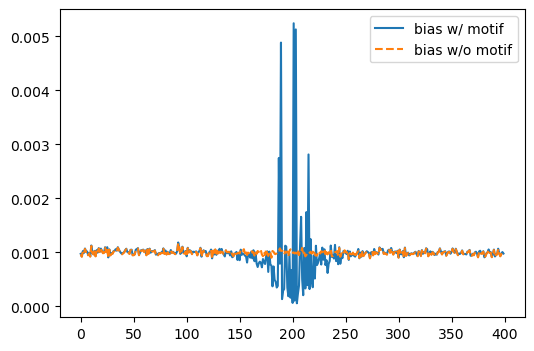

In [59]:
plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias,save_path = "./Plots/EDFig5/PanelED5f_top.svg", start=300,end=700)

### WC_0047

In [2]:
with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    model_bias = tf.keras.models.load_model("./ChromBPNet/chrombpnet_models/Mlig/fold_1/epidermal/epidermal_bias_model_scaled.h5")    
    model = tf.keras.models.load_model("./ChromBPNet/chrombpnet_models/Mlig/fold_1/epidermal/epidermal_chrombpnet.h5")  
    model_wobias = tf.keras.models.load_model("./ChromBPNet/chrombpnet_models/Mlig/fold_1/epidermal/epidermal_chrombpnet_wo_bias.h5") 

2024-04-26 01:47:49.506167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-26 01:47:49.507014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-26 01:47:49.515892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-26 01:47:49.516600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-26 01:47:49.517282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [3]:
INP_LEN = model_bias.input_shape[1]
OUT_LEN = model_bias.output_shape[0][1]

INP_LEN, OUT_LEN

(2114, 1000)

In [4]:
TEST_CHR = ["ML45REF0001", "ML45REF0002", "ML45REF0004", "ML45REF0003", "ML45REF0005", "ML45REF0006", "ML45REF0007", "ML45REF0008", "ML45REF0009", "ML45REF0008", "ML45REF0020", "ML45REF0019", "ML45REF0032", "ML45REF0035", "ML45REF0023", "ML45REF0026", "ML45REF0016", "ML45REF0022"]
VAL_CHR = ["ML45REF0009", "ML45REF0010", "ML45REF0011", "ML45REF0027", "ML45REF0056", "ML45REF0055", "ML45REF0021", "ML45REF0022", "ML45REF0023", "ML45REF0028", "ML45REF0110", "ML45REF0031", "ML45REF0030", "ML45REF0032", "ML45REF0033", "ML45REF0144", "ML45REF0167", "ML45REF0158"]

In [8]:
test_peaks_seqs, test_peaks_cts, test_nonpeaks_seqs, test_nonpeaks_cts = \
    load_test_data("./ChromBPNet/chrombpnet_models/Mlig/fold_1/epidermal/epidermal_filtered.peaks.bed", 
                   "./ChromBPNet/chrombpnet_models/Mlig/fold_1/epidermal/epidermal_filtered.nonpeaks.bed", 
                   "./Refs/Mlig_4_5.v5/Mlig_4_5.fa", 
                   "./ChromBPNet/Coverage/Mlig/epidermal_all_unstranded.bw",
                   TEST_CHR, INP_LEN, OUT_LEN)

In [10]:
def plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias,save_path, start=450, end=550):
    plt.rcParams["figure.figsize"] = (6,4)
    width = end - start
    plt.plot(range(width), pred_unplug_bias[:, start:end].mean(0), label='corrected')
    plt.plot(range(width), pred_wo_motif_w_bias[:, start:end].mean(0), '--', label='uncorrected w/o motif')
    plt.ylim([0.00025,0.0022])
    plt.savefig(save_path,format="svg")

    plt.legend()
    plt.show()

    plt.plot(range(width), raw_mot_bias[:, start:end].mean(0), label='bias w/ motif')
    plt.plot(range(width), raw_bias[:, start:end].mean(0), '--', label='bias w/o motif')
    plt.legend()
    plt.show()

In [11]:
raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias, wo_mot_w_bias_cts, w_mot_w_bias_cts \
    = profiles_for_motif(model, model_bias, model_wobias, test_nonpeaks_seqs[1000:3000], "CTCAACTCACTCAACTCA")

2024-04-26 01:48:33.530520: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


63/63 [==============================] - 17s 276ms/step


In [12]:
np.median(w_mot_w_bias_cts - wo_mot_w_bias_cts)

0.004245043

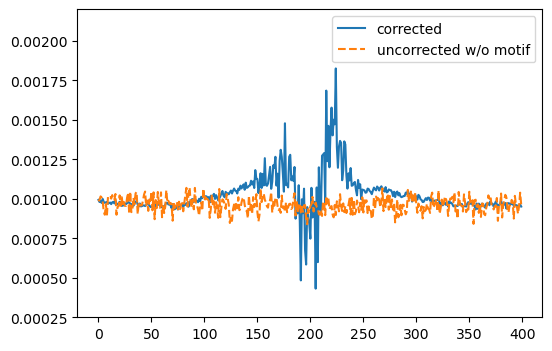

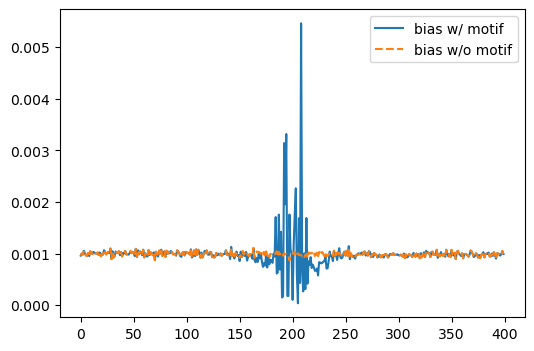

In [13]:
plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias,save_path="./Plots/EDFig5/PanelED5f_middle.svg",start=300,end=700)

### WC_0328

In [39]:
### Don't forget to update these paths 
with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    model_bias = tf.keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/intestine/intestine_bias_model_scaled.h5")    
    model = tf.keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/intestine/intestine_chrombpnet.h5")  
    model_wobias = tf.keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/intestine/intestine_chrombpnet_wo_bias.h5") 

/opt/conda/lib/python3.9/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning:  is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


In [40]:
INP_LEN = model_bias.input_shape[1]
OUT_LEN = model_bias.output_shape[0][1]

INP_LEN, OUT_LEN

(2114, 1000)

In [41]:
TEST_CHR = ["SM_V7_4","SM_V7_2","SM_V7_1","SM_V7_5","SM_V7_6","SM_V7_7"]
VAL_CHR = ["SM_V7_3"]

In [42]:
## Don't forget to update these paths 
test_peaks_seqs, test_peaks_cts, test_nonpeaks_seqs, test_nonpeaks_cts = \
    load_test_data("./ChromBPNet/chrombpnet_models/Sman/fold_1/intestine/intestine_filtered.peaks.bed", 
                   "./ChromBPNet/chrombpnet_models/Sman/fold_1/intestine/intestine_filtered.nonpeaks.bed", 
                   "./Refs/SM_V7/Schisto_PRJEA36577.WBPS15.genomic.fa", 
                   "./ChromBPNet/Coverage/Sman/intestine_unstranded.bw",
                   TEST_CHR, INP_LEN, OUT_LEN)

In [43]:
def plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias,save_path, start=450, end=550):
    plt.rcParams["figure.figsize"] = (6,4)
    width = end - start
    plt.plot(range(width), pred_unplug_bias[:, start:end].mean(0), label='corrected')
    plt.plot(range(width), pred_wo_motif_w_bias[:, start:end].mean(0), '--', label='uncorrected w/o motif')
    plt.ylim([0.00025,0.0022])
    plt.savefig(save_path,format="svg")

    plt.legend()
    plt.show()

    plt.plot(range(width), raw_mot_bias[:, start:end].mean(0), label='bias w/ motif')
    plt.plot(range(width), raw_bias[:, start:end].mean(0), '--', label='bias w/o motif')
    plt.legend()
    plt.show()

In [44]:
raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias, wo_mot_w_bias_cts, w_mot_w_bias_cts \
    = profiles_for_motif(model, model_bias, model_wobias,test_nonpeaks_seqs[1000:3000], "GCGCGTGCACTGTA")

63/63 [==============================] - 33s 532ms/step


In [45]:
np.median(w_mot_w_bias_cts - wo_mot_w_bias_cts)

0.05860591

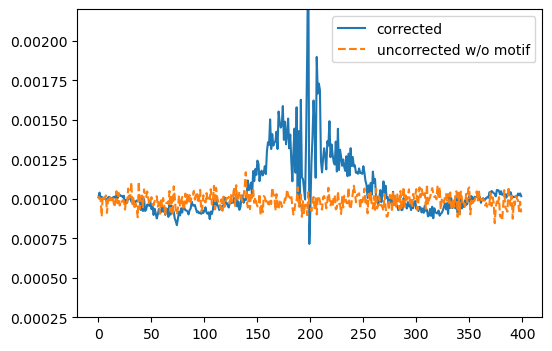

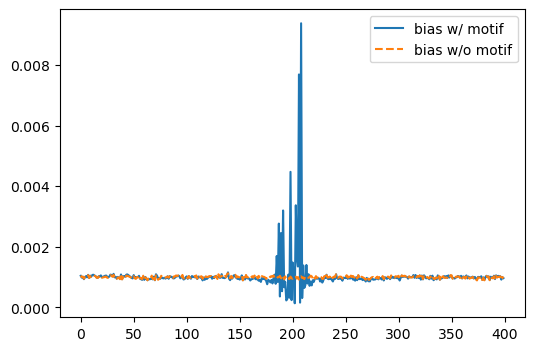

In [46]:
plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias,save_path='./Plots/EDFig5/PanelED5f_bottom.svg', start=300, end=700)